In [1]:
import sys
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torchvision
import torch
import math
import pandas as pd
import datetime
from tqdm import tqdm
import glob
from scipy import signal

/home/yhbedoya/VirtualEnvs/SHMmae_venv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
os.chdir("/home/yhbedoya/Repositories/SHM-MAE/")
import models_audio_mae

In [3]:
# define the utils

def show_image(frequencies, times, spectrogram, title='', diffFlag=False):
    #plt.figure(figsize=(10, 5))
    plt.title(f'spectrogram from PSD: {title}')
    #plt.pcolormesh(times, frequencies, 10*np.log10(np.squeeze(spectrogram)), vmin=-150, vmax=-50)
    if not diffFlag:
      plt.pcolormesh(times, frequencies, 10*np.squeeze(spectrogram), vmin=-150, vmax=-50)
    else:
      plt.pcolormesh(times, frequencies, 10*np.squeeze(spectrogram))
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.colorbar(format="%+2.f", label='dB')
    #return

def prepare_model(chkpt_dir, arch='audioMae_vit_base'):
    # build model
    model = getattr(models_audio_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(frequencies, times, spectrogram, model, test):
    
    #gnr_mean = 7.425835578987807e-08
    #gnr_std = 5.845655574487041e-07

    gnr_max = -2.8994614545810333
    gnr_min = -23.900163095340584

    x = torch.transpose(spectrogram, 1, 2) #shape [1,80,100]
    #x = x - gnr_mean
    #x = x / gnr_std

    #MIN MAX SCALER
    x = (x -gnr_min) /(gnr_max-gnr_min) 

    # make it a batch-like
    x = x.unsqueeze(dim=0)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.8)
    #y = model_mae.unpatchify(y).detach().cpu()
    y = y.type(torch.float64)
    y = model.unpatchify(y).detach().cpu()
    
    y = torch.transpose(torch.squeeze(torch.squeeze(input=y)),0,1)


    #y = torch.squeeze(torch.squeeze(input=out))
    y = y * (gnr_max-gnr_min) 
    y = y + gnr_min

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    #mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    mask = torch.transpose(torch.squeeze(torch.squeeze(input=mask)),0,1)
    #print(f'mask shape {mask.shape}')
    #x = torch.einsum('nchw->nhwc', x)
  

    # masked image
    spectrogram = torch.squeeze(spectrogram)
    #print(f'spectrogram shape {spectrogram.shape}')
    im_masked = spectrogram * (1 - mask)
    #print(f'inmask shape {im_masked.shape}')

    # MAE reconstruction pasted with visible patches
    im_paste = spectrogram * (1 - mask) + y * mask
    #im_paste2 = spectrogram * (1 - mask) + ((y + torch.abs(0.6*torch.min(y))) * mask)
    #print(f'im_paste shape {im_paste.shape}')

    #diff reconstruction original
    diff = torch.abs(spectrogram - im_paste)

    mse = (np.square(spectrogram - im_paste)).mean()

    if test:
      return mse

    print(f"MSE: {mse}")

    plt.title(f"MSE: {mse}")

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [30, 8]

    plt.subplot(1, 4, 1)
    show_image(frequencies, times, spectrogram, "original")

    plt.subplot(1, 4, 2)
    show_image(frequencies, times, im_masked, "masked")

    plt.subplot(1, 4, 3)
    show_image(frequencies, times, im_paste, "reconstruction + visible")

    plt.subplot(1, 4, 4)
    show_image(frequencies, times, diff, "Difference original vs prediction", diffFlag=True)

    #plt.show()

In [4]:
from torch.utils.data import Dataset
import torch
import glob
import pandas as pd
import datetime
import os
import math
from tqdm import tqdm
import numpy as np
import random

from scipy import signal

from pathlib import Path

class SHMDataset(Dataset):

    def __init__(self, data_path, day_start, num_days):
        self.day_start = day_start#datetime.date(2019,5,24)
        self.num_days = num_days#4
        self.path = data_path #Path("/home/yhbedoya/Repositories/SHM-MAE/INSIST_SS335/")
        self.data = self._readCSV()
        self.sampleRate = 100
        self.frameLength = 198
        self.stepLength = 10
        self.windowLength= 990
        self.windowStep = 100
        self.data, self.limits, self.totalWindows, self.min, self.max = self._partitioner()

    def __len__(self):
        return self.totalWindows

    def __getitem__(self, index):
        start, end, power = self.limits[index]
        slice = self.data[start:end]
        frequencies, times, spectrogram = self._transformation(slice)
        spectrogram = torch.unsqueeze(torch.tensor(spectrogram, dtype=torch.float64), 0)
        NormSpect = self._normalizer(spectrogram).type(torch.float16)
        #print(f'type {type(NormSpect)}, inp shape: {slice.shape} out shape: {NormSpect.shape}')
        return frequencies, times, spectrogram

    def _readCSV(self):
        print(f'reading CSV files')
        
        ldf = []
        for x in range(self.num_days):
            yy, mm, dd = (self.day_start + datetime.timedelta(days=x)).strftime('%Y,%m,%d').split(",")
            date = f"{int(yy)}{int(mm)}{int(dd)}"
            df = pd.read_csv(self.path + f"ss335-acc-{date}.csv")
            ldf.append(df.drop(['x','y', "year", "month", "day", "Unnamed: 0"], axis=1))
        df = pd.concat(ldf).sort_values(by=['sens_pos', 'ts'])
        df = df.reset_index(drop=True)

        new_dict = {
            "ts": [],
            "sens_pos": [],
            "z": [],
        }
        conv = (1*2.5)*2**-15

        print(f'Creating the dataframe')
        for i in tqdm(range(len(df))):
            if i >= 5000:
                break
            row = df["z"][i]
            data_splited = row.replace("\n", "").replace("[", "").replace("]", "").split(" ")
            #data_splited = df["z"][i].split(" ")
            ts = datetime.datetime.utcfromtimestamp(df["ts"][i]/1000)
            sens = df["sens_pos"][i]
            
            for idx, data in enumerate(data_splited):
                if data == "":
                    continue
                z = int(data)  
                new_dict["ts"].append(ts + idx*datetime.timedelta(milliseconds=10))
                new_dict["z"].append(z * conv)
                new_dict["sens_pos"].append(sens)

        df_new = pd.DataFrame(new_dict)
        print(f'Finish data reading')
        return df_new

    def _partitioner(self):
        sensors = self.data['sens_pos'].unique().tolist()
        print(f'start partitioner')
        partitions = {}
        cumulatedWindows = 0
        limits = dict()
        print(f'Generating windows')
        for sensor in tqdm(sensors):
            sensorData = self.data[self.data['sens_pos']==sensor]
            totalFrames = sensorData.shape[0]
            totalWindows = math.ceil((totalFrames-self.windowLength)/self.windowStep)
            start = cumulatedWindows
            cumulatedWindows += totalWindows
            end = cumulatedWindows
            indexStart = sensorData.index[0]
            partitions[sensor]= (start, end, indexStart)

        timeData = torch.tensor(self.data["z"].values, dtype=torch.float64)
        cummulator = -1

        mins = list()
        maxs = list()
        print(f'Defining useful windows limits')
        noiseFreeSpaces = 1
        indexes = list(range(0, cumulatedWindows))
        random.shuffle(indexes)
        
        for index in tqdm(indexes):
            if cummulator >= 500000:
                break
            for k,v in partitions.items():
                if index in range(v[0], v[1]):
                    start = v[2]+(index-v[0])*self.windowStep
                    filteredSlice = self.butter_bandpass_filter(timeData[start: start+self.windowLength], 0, 50, self.sampleRate)
                    signalPower = self.power(filteredSlice)

                    if signalPower>1.25*10**-6:
                        cummulator += 1
                        limits[cummulator] = (start, start+self.windowLength, signalPower)
                        slice = timeData[start:start+self.windowLength]
                        frequencies, times, spectrogram = self._transformation(torch.tensor(slice, dtype=torch.float64))
                        mins.append(np.min(np.array(spectrogram)))
                        maxs.append(np.max(np.array(spectrogram)))
                    break
        print(f'Total windows in dataset: {cummulator}')
        min = np.min(np.array(mins))
        max = np.max(np.array(maxs))     
        print(f'General min: {min}')
        print(f'General max: {max}')
        return timeData, limits, cummulator, min, max

    def _transformation(self, slice):
        sliceN = slice-torch.mean(slice)
        frequencies, times, spectrogram = signal.spectrogram(sliceN,self.sampleRate,nfft=self.frameLength,noverlap=(self.frameLength - self.stepLength), nperseg=self.frameLength,mode='psd')

        return frequencies, times, np.log10(spectrogram)
    
    def _normalizer(self, spectrogram):
        spectrogramNorm = (spectrogram - self.min) / (self.max - self.min)
        return spectrogramNorm
    
    def butter_bandpass(self, lowcut, highcut, fs, order=5):
        return signal.butter(order, [1, 49], fs=fs, btype='band')

    def butter_bandpass_filter(self, slice, lowcut, highcut, fs, order=5):
        sliceN = slice-np.mean(np.array(slice))
        b, a = self.butter_bandpass(lowcut, highcut, fs, order=order)
        y = signal.lfilter(b, a, sliceN)
        return y

    def power(self, slice):
        signalPower = np.sqrt(np.mean(np.array(slice)**2))**2
        return signalPower

In [5]:
data_path = "/home/yhbedoya/Repositories/SHM-MAE/INSIST_SS335/"
day_start = datetime.date(2019,5,25)
num_days = 1
InsistDataset = SHMDataset(data_path=data_path, day_start=day_start, num_days=num_days)

reading CSV files
Creating the dataframe


  0%|          | 5000/3369325 [00:00<06:24, 8740.33it/s]


Finish data reading
start partitioner
Generating windows


100%|██████████| 1/1 [00:00<00:00, 26.77it/s]


Defining useful windows limits


100%|██████████| 4991/4991 [00:01<00:00, 3382.17it/s]

Total windows in dataset: 14
General min: -13.886871670496229
General max: -5.288938382604075


In [6]:
#Load model
chkpt_dir = '/home/yhbedoya/Repositories/SHM-MAE/AnomalyDetection on INSIST/INSIST_small/output_dir_INSIST_small/checkpoint-199.pth'
model_mae = prepare_model(chkpt_dir, 'audioMae_vit_base')
print('Model loaded.')

<All keys matched successfully>
Model loaded.


In [7]:
errors = []

for i in tqdm(range(len(InsistDataset))):
    frequencies, times, spectrogram = InsistDataset[i]
    error = run_one_image(frequencies, times, spectrogram, model_mae, True)
    errors.append(error)

errors = np.array(errors)

100%|██████████| 14/14 [00:01<00:00, 11.89it/s]


In [9]:
print(errors)

[0.18460748 0.15796499 0.16030129 0.15456419 0.17926877 0.18867041
 0.16942185 0.15306487 0.16876687 0.17217167 0.1587687  0.19447756
 0.15942702 0.1908423 ]


In [12]:
with open('errorsPre.npy', 'wb') as f:
    np.save(f, errors)

In [13]:
with open('errorsPre.npy', 'rb') as f:
    a = np.load(f)

print(a)

[0.18460748 0.15796499 0.16030129 0.15456419 0.17926877 0.18867041
 0.16942185 0.15306487 0.16876687 0.17217167 0.1587687  0.19447756
 0.15942702 0.1908423 ]


MSE: 0.15873152607658667


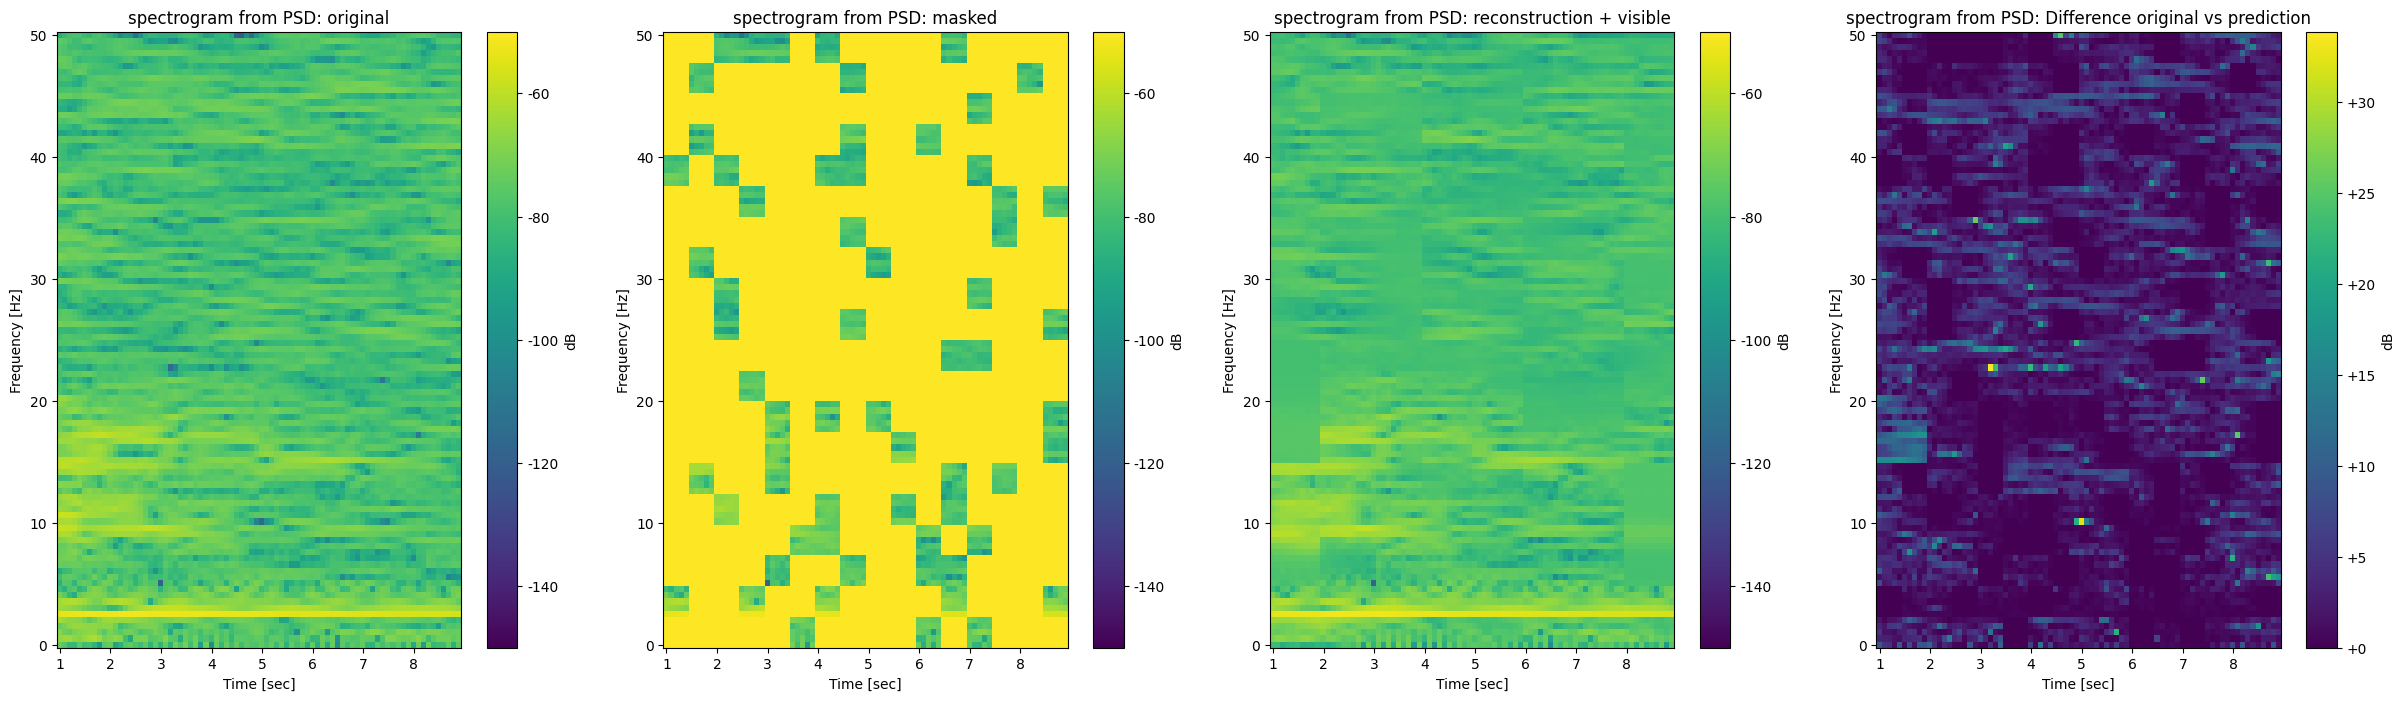

In [28]:
frequencies, times, spectrogram = InsistDataset[3]
run_one_image(frequencies, times, spectrogram, model_mae, False)